# Truth deck
Compare truth deck sentences (n=374) to:
1. RegEx
2. NER
3. GPT

Similarity measure:
- Jaro-Winkler score (characters in common - better for shorter strings; output is ratio)

Decide whether to split the predictions by delimiter or calculate full span overlap

In [1]:
import pandas as pd
import numpy as np
from pyjarowinkler.distance import get_jaro_distance # to calculate a similarity score for a pair of strings

## Truth deck sentences

In [2]:
df = pd.read_json('/nfs/turbo/isr-slafia/specimen/specimen_truth_deck.jsonl', lines=True).reset_index() # expose index
df["manual_codes"] = ""

for index, row in df.iterrows():
    specimens = []
    spans = row["spans"]
    for i in spans:
        ref = i.get("text")
        specimens.append(ref)
    result = (", ".join(filter(None,specimens))) # may change delimiter based on comparison metric
    df["manual_codes"][index] = result

df['manual_codes'].replace("", "none", inplace=True) # replace empty codes with NA or none for similarity measure
df

/tmp/ipykernel_910818/777168922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["manual_codes"][index] = result


,index,text,meta,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,answer,_timestamp,manual_codes
0,0,Sixteen skeletons representing five species (S...,{'meta': '{'95dd24bd-27c4-bf8d-5994-90667d4165...,-68186736,-1302981997,False,[],"[{'text': 'Sixteen', 'start': 0, 'end': 7, 'id...",ner_manual,accept,1677099355,none
1,1,A collection of G. affinis in 1936 from an irr...,{'meta': '{'685e406b-8171-31eb-9766-c1439c9afc...,-998766942,1803169322,False,"[{'text': 'UMMZ 110467', 'start': 78, 'end': 8...","[{'text': 'A', 'start': 0, 'end': 1, 'id': 0, ...",ner_manual,accept,1677099360,UMMZ 110467
2,2,Type-material is deposited in the following in...,{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,2030282880,-922568282,False,[],"[{'text': 'Type', 'start': 0, 'end': 4, 'id': ...",ner_manual,accept,1677099370,none
3,3,"Holotype and most paratypes-ZISP, 2 female par...",{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,1598185019,-1646348169,False,[],"[{'text': 'Holotype', 'start': 0, 'end': 8, 'i...",ner_manual,accept,1677099378,none
4,4,"Holotype and most paratypes-ZISP, 2 male and 2...",{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,-406055451,-682729028,False,[],"[{'text': 'Holotype', 'start': 0, 'end': 8, 'i...",ner_manual,accept,1677099382,none
...,...,...,...,...,...,...,...,...,...,...,...,...
370,370,Voucher specimens of the mite species bearing ...,{'meta': '{'d3b564b0-8be0-4c3e-5c94-938160c6b3...,1173569346,136622145,False,[],"[{'text': 'Voucher', 'start': 0, 'end': 7, 'id...",ner_manual,accept,1677106950,none
371,371,Additional radiographs of juvenile (305 mm tot...,{'meta': '{'d3447490-96fd-35d0-adf2-0806e52146...,302278082,59311565,False,"[{'text': 'UMMZ 70046', 'start': 57, 'end': 67...","[{'text': 'Additional', 'start': 0, 'end': 10,...",ner_manual,accept,1677106953,"UMMZ 70046, UMMZ 157208"
372,372,Two other paratypes have been deposited in the...,{'meta': '{'4c1f59df-f6b4-160b-d466-c7725df567...,1271214344,-531623889,False,[],"[{'text': 'Two', 'start': 0, 'end': 3, 'id': 0...",ner_manual,accept,1677106955,none
373,373,T (UMMZ 43037) and paratypes (UMMZ 42991-43036...,{'meta': '{'992e7dea-0374-3263-4a06-09aa827acd...,993384249,-747251974,False,"[{'text': 'UMMZ 43037', 'start': 3, 'end': 13,...","[{'text': 'T', 'start': 0, 'end': 1, 'id': 0, ...",ner_manual,accept,1677106962,UMMZ 43037


Describe the variety of labels in the truth deck

In [3]:
print("No specimens: ",len(df[df.manual_codes=='none']))
print("Has 1+ specimens: ",len(df[df.manual_codes!='none']))

No specimens:  236
Has 1+ specimens:  139


In [4]:
df_codes = df[df.manual_codes!='none']
print("Unique codes: ",df_codes.assign(manual_codes=df_codes.manual_codes.str.split(",").explode("manual_codes")).manual_codes.nunique())

Unique codes:  77


## RegEx sentences

In [5]:
reg_res = pd.read_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_pattern.csv')
reg_res['specimen_prediction'].replace(np.nan, "none", inplace=True) # replace empty codes with none for string similarity measure
reg_res = reg_res.drop(columns=['manual_codes'])
df_res = pd.merge(df, reg_res, on=['index'])
df_res['sim_score'] = [get_jaro_distance(x, y) for x, y in zip(df_res['manual_codes'], df_res['specimen_prediction'])]
df_res = df_res.rename(columns={"text_x":"text"})
df_res = df_res[['index','text','meta','manual_codes','specimen_prediction','sim_score']]
df_res.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_pattern_v2.csv',index=False)
df_res

,index,text,meta,manual_codes,specimen_prediction,sim_score
0,0,Sixteen skeletons representing five species (S...,{'meta': '{'95dd24bd-27c4-bf8d-5994-90667d4165...,none,none,1.00
1,1,A collection of G. affinis in 1936 from an irr...,{'meta': '{'685e406b-8171-31eb-9766-c1439c9afc...,UMMZ 110467,UMMZ 110467,1.00
2,2,Type-material is deposited in the following in...,{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,none,none,1.00
3,3,"Holotype and most paratypes-ZISP, 2 female par...",{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,none,none,1.00
4,4,"Holotype and most paratypes-ZISP, 2 male and 2...",{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,none,none,1.00
...,...,...,...,...,...,...
370,370,Voucher specimens of the mite species bearing ...,{'meta': '{'d3b564b0-8be0-4c3e-5c94-938160c6b3...,none,none,1.00
371,371,Additional radiographs of juvenile (305 mm tot...,{'meta': '{'d3447490-96fd-35d0-adf2-0806e52146...,"UMMZ 70046, UMMZ 157208","UMMZ 70046, UMMZ 157208",1.00
372,372,Two other paratypes have been deposited in the...,{'meta': '{'4c1f59df-f6b4-160b-d466-c7725df567...,none,none,1.00
373,373,T (UMMZ 43037) and paratypes (UMMZ 42991-43036...,{'meta': '{'992e7dea-0374-3263-4a06-09aa827acd...,UMMZ 43037,"UMMZ 43037, UMMZ 42991 43036",0.87


In [6]:
df_res.sim_score.describe()

count    375.000000
mean       0.868453
std        0.318000
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sim_score, dtype: float64

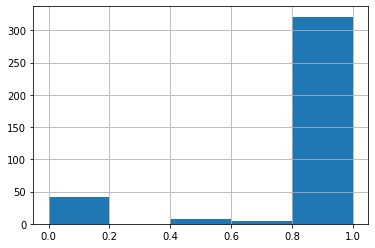

In [7]:
df_res.sim_score.hist(bins=5);

## NER sentences

In [8]:
ner_res = pd.read_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_ner.csv')
ner_res['specimen_prediction'].replace(np.nan, "none", inplace=True) # replace empty codes with none for string similarity measure
df_ner = pd.merge(df, ner_res, on=['index'])
df_ner['sim_score'] = [get_jaro_distance(x, y) for x, y in zip(df_ner['manual_codes'], df_ner['specimen_prediction'])]
df_ner = df_ner.rename(columns={"text_x":"text"})
df_ner = df_ner[['index','text','meta','manual_codes','specimen_prediction','sim_score']]
df_ner.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_ner_v2.csv',index=False)
df_ner

,index,text,meta,manual_codes,specimen_prediction,sim_score
0,0,Sixteen skeletons representing five species (S...,{'meta': '{'95dd24bd-27c4-bf8d-5994-90667d4165...,none,UMMZ,0.00
1,1,A collection of G. affinis in 1936 from an irr...,{'meta': '{'685e406b-8171-31eb-9766-c1439c9afc...,UMMZ 110467,UMMZ 110467,1.00
2,2,Type-material is deposited in the following in...,{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,none,UMMZ,0.00
3,3,"Holotype and most paratypes-ZISP, 2 female par...",{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,none,UMMZ,0.00
4,4,"Holotype and most paratypes-ZISP, 2 male and 2...",{'meta': '{'35783f66-2114-c2d6-50ea-1324862f78...,none,UMMZ,0.00
...,...,...,...,...,...,...
370,370,Voucher specimens of the mite species bearing ...,{'meta': '{'d3b564b0-8be0-4c3e-5c94-938160c6b3...,none,UMMZ and,0.00
371,371,Additional radiographs of juvenile (305 mm tot...,{'meta': '{'d3447490-96fd-35d0-adf2-0806e52146...,"UMMZ 70046, UMMZ 157208","UMMZ 70046, UMMZ 157208",1.00
372,372,Two other paratypes have been deposited in the...,{'meta': '{'4c1f59df-f6b4-160b-d466-c7725df567...,none,UMMZ,0.00
373,373,T (UMMZ 43037) and paratypes (UMMZ 42991-43036...,{'meta': '{'992e7dea-0374-3263-4a06-09aa827acd...,UMMZ 43037,"UMMZ 43037, UMMZ 42991",0.89


In [9]:
df_ner.sim_score.describe()

count    375.000000
mean       0.487013
std        0.486912
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: sim_score, dtype: float64

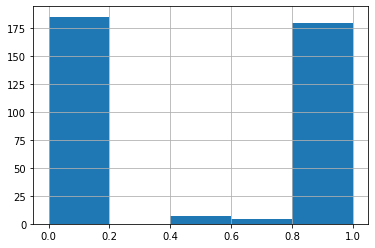

In [10]:
df_ner.sim_score.hist(bins=5);

## GPT-3 sentences

In [11]:
df_gpt = pd.read_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_gpt.csv')
df_gpt = df_gpt[['index','text','meta','manual_codes','gpt_answer','sim_score']]
df_gpt.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_gpt_v2.csv',index=False)
df_gpt

,index,text,meta,manual_codes,gpt_answer,sim_score
0,0,Sixteen skeletons representing five species (S...,"{'meta': ""{'95dd24bd-27c4-bf8d-5994-90667d4165...",NaN,"UMMZ, NME",0.00
1,1,A collection of G. affinis in 1936 from an irr...,"{'meta': ""{'685e406b-8171-31eb-9766-c1439c9afc...",UMMZ 110467,UMMZ 110467,1.00
2,2,Type-material is deposited in the following in...,"{'meta': ""{'35783f66-2114-c2d6-50ea-1324862f78...",NaN,"UMMZ, ZISP",0.00
3,3,"Holotype and most paratypes-ZISP, 2 female par...","{'meta': ""{'35783f66-2114-c2d6-50ea-1324862f78...",NaN,"ZISP, UMMZ",0.00
4,4,"Holotype and most paratypes-ZISP, 2 male and 2...","{'meta': ""{'35783f66-2114-c2d6-50ea-1324862f78...",NaN,"ZISP, UMMZ",0.00
...,...,...,...,...,...,...
370,370,Voucher specimens of the mite species bearing ...,"{'meta': ""{'d3b564b0-8be0-4c3e-5c94-938160c6b3...",NaN,BMOC and HK,0.00
371,371,Additional radiographs of juvenile (305 mm tot...,"{'meta': ""{'d3447490-96fd-35d0-adf2-0806e52146...","UMMZ 70046, UMMZ 157208","UMMZ 70046, UMMZ 157208",1.00
372,372,Two other paratypes have been deposited in the...,"{'meta': ""{'4c1f59df-f6b4-160b-d466-c7725df567...",NaN,"UMMZ, NSMT",0.00
373,373,T (UMMZ 43037) and paratypes (UMMZ 42991-43036...,"{'meta': ""{'992e7dea-0374-3263-4a06-09aa827acd...",UMMZ 43037,"UMMZ 43037, UMMZ 42991-43036",0.87


In [12]:
df_gpt.sim_score.describe()

count    375.000000
mean       0.430267
std        0.434857
min        0.000000
25%        0.000000
50%        0.510000
75%        0.915000
max        1.000000
Name: sim_score, dtype: float64

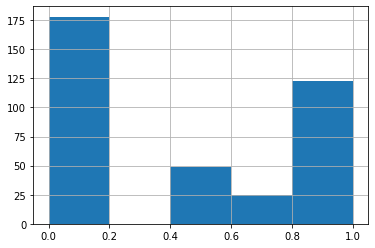

In [13]:
df_gpt.sim_score.hist(bins=5);